In [1]:
import numpy as np
import pandas as pd

# import tensorflow as tf

from utils.utils import *
from utils.Atc_code import *
# from utils.utils_baseline_svm import *
from utils.utils_suggest_from_unlabeled import *

# from utils.kwargs_file import kwargs_lin_data_init, kwargs_svm
from utils.kwargs_file import kwargs_lin_data_init

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

# import csv

# from sklearn.feature_extraction import DictVectorizer
# from sklearn import svm

# from collections import Counter, OrderedDict
# from itertools import combinations

# from math import inf
# from time import time

In [2]:
# figure_dir = 'figures/'
figure_dir = '../Automated_categorization_medication_lab/Latex/figures/'

In [3]:
# init data
# labeled data
x, y, n, main_data = init_data()
# labeled data from external sources
x_wiki, y_wiki = init_data_other_atc('wiki_atc_code')
x_drugbank, y_drugbank = init_data_other_atc('drugbank_atc_code')
x_external = x_wiki + x_drugbank
y_external = y_wiki + y_drugbank

# unlabeled data
x_unlabeled = main_data['FREETXT'][n:]

# removing text fields shorter than sliding window width
xy_external = [(xx,yy) for (xx,yy) 
               in zip(x_external, y_external) 
               if len(xx) >= kwargs_lin_data_init.ngram_width]
x_external, y_external = zip(*xy_external)

x_unlabeled = x_unlabeled.loc[[len(k) >= kwargs_lin_data_init.ngram_width 
                               for k in x_unlabeled]]

In [4]:
fig_height = 15
fig_width = 15

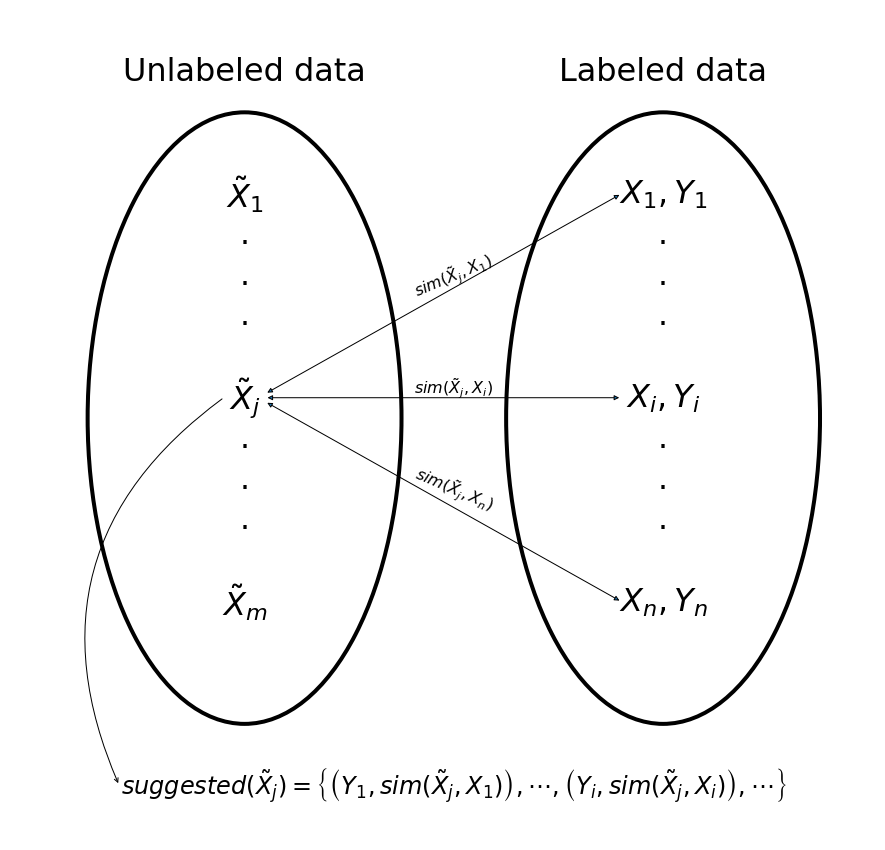

In [5]:
## labeled-unlabeled illustraion
fig = plt.figure(figsize=(fig_width, fig_height))  # width, height

el_height = 30
el_width = 15

el1 = Ellipse((-10, 0), el_width, el_height, 
             facecolor='none',
             edgecolor='black',
             linewidth=4,
             alpha=1)

el2 = Ellipse((10, 0), el_width, el_height, 
             facecolor='none',
             edgecolor='black',
             linewidth=4,
             alpha=1)

ax = fig.add_subplot(111) 

ax.add_artist(el1)
ax.add_artist(el2)
# el1.set_clip_box(ax.bbox)

fontsize_set = 32
fontsize = 32

# plot a dot
plot_dot = lambda x, dist: \
    ax.annotate('.', xy=(x, el_height / 2 - dist),
                ha='center', va='center',
                fontsize=fontsize)

## unlabeled data ellipse
ax.annotate('Unlabeled data', xy=(-10, el_height / 2 + 2),
            ha='center', va='center',
            fontsize=fontsize_set)

## plot x, ..., x, ..., x
ax.annotate(r'$\tilde{X}_1$', xy=(-10, el_height / 2 - 4),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(-10, _) for _ in [6, 8, 10]]
ax.annotate(r'$\tilde{X}_j$', xy=(-10, el_height / 2 - 14),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(-10, _) for _ in [16, 18, 20]]
ax.annotate(r'$\tilde{X}_m$', xy=(-10, el_height / 2 - 24),
            ha='center', va='center',
            fontsize=fontsize)


## labeled data ellipse
ax.annotate('Labeled data', xy=(10, el_height / 2 + 2),
            ha='center', va='center',
            fontsize=fontsize_set)

## plot x, ..., x, ..., x
ax.annotate(r'$X_1, Y_1$', xy=(10, el_height / 2 - 4),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(10, _) for _ in [6, 8, 10]]
ax.annotate(r'$X_i, Y_i$', xy=(10, el_height / 2 - 14),
            ha='center', va='center',
            fontsize=fontsize)
# plot 3 dot, horizontally
[plot_dot(10, _) for _ in [16, 18, 20]]
ax.annotate(r'$X_n, Y_n$', xy=(10, el_height / 2 - 24),
            ha='center', va='center',
            fontsize=fontsize)

# arrows from ~X_j
ax.annotate('',
            xy=(-10 + 1, 0.2 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 4),
            arrowprops=dict(arrowstyle='<|-|>'))
ax.annotate('',
            xy=(-10 + 1, 0.0 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 14),
            arrowprops=dict(arrowstyle='<|-|>'))
ax.annotate('',
            xy=(-10 + 1, - 0.2 + el_height / 2 - 14),
            xytext=(10 - 2, el_height / 2 - 24),
            arrowprops=dict(arrowstyle='<|-|>'))

## similarity text
ax.annotate(r'$sim(\tilde{X}_j, X_1)$', xy=(0, 7),
            ha='center', va='center',
            fontsize=fontsize*0.5, 
            rotation=23)

ax.annotate(r'$sim(\tilde{X}_j, X_i)$', xy=(0, 1.5),
            ha='center', va='center',
            fontsize=fontsize*0.5)

ax.annotate(r'$sim(\tilde{X}_j, X_n)$', xy=(0, -3.5),
            ha='center', va='center',
            fontsize=fontsize*0.5, 
            rotation=-23)

sim_eq = r'$suggested(\tilde{X}_j) = \left \{ \left( Y_1, sim(\tilde{X}_j, X_1) \right),\cdots ,\left( Y_i, sim(\tilde{X}_j, X_i) \right),\cdots\right \}$'
ax.annotate(sim_eq, xy=(0, -18),
            ha='center', va='center',
            fontsize=fontsize*0.75)

ax.annotate('',
            xy=(-16, -18), xycoords='data',
            xytext=(-10 - 1, el_height / 2 - 14), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.4"))

ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])

ax.axis('off')

# plt.show()

plt.savefig(figure_dir + 'unlabeled_labeled_fig.pdf', bbox_inches='tight')

# text and math examples
# https://matplotlib.org/users/text_intro.html
# https://matplotlib.org/users/mathtext.html
# http://matplotlib.org/examples/pylab_examples/tex_unicode_demo.html

# plotting examples
# http://matplotlib.org/examples/pylab_examples/annotation_demo.html
# https://matplotlib.org/users/annotations_guide.html
# http://matplotlib.org/examples/pylab_examples/annotation_demo3.html


In [5]:
"""
Load data from **internal** sources from files, after files have been generated.
Generate some plots to try and understand the label suggestions results.
"""
# load data for figures
sim_dict_filtered = load('resources/sim_dict_filtered_5_8')
# transform the ATC codes into class instances
sim_dict_filtered = \
    {k:[(Atc_code(atc), sim) for atc, sim in v] 
     for k,v in sim_dict_filtered.items()}

label_suggestion_summary = []
for threshold in np.linspace(0.5,1.0, 51):
# for threshold in np.linspace(0.5,1.0, 3):
    _, _, number_of_distinct_labels, \
        labels_sim_tup = \
        get_filtered_suggestion_results(threshold, 
                                        sim_dict_filtered)
    label_suggestion_summary.append(
        record_threshold_data(
            threshold, 
            number_of_distinct_labels, 
            labels_sim_tup, 
            x_unlabeled,
            y, 
            kwargs_lin_data_init)        
        )

In [6]:
label_suggestion_summary =  \
    pd.DataFrame(label_suggestion_summary)
    
# some float formatting
label_suggestion_summary_formatted = \
    label_suggestion_summary.head(5).style.format(
        {'Mean # suggestions': '{:.2f}', 
         'Mean similarity': '{:.2f}', 
         'Min similarity': '{:.2f}', 
         'Unanimous mean similarity': '{:.2f}', 
         'Mean common ATC levels (norm)': '{:.2f}', 
         'Mean common ATC levels, non-unanimous (norm)': '{:.2f}'})

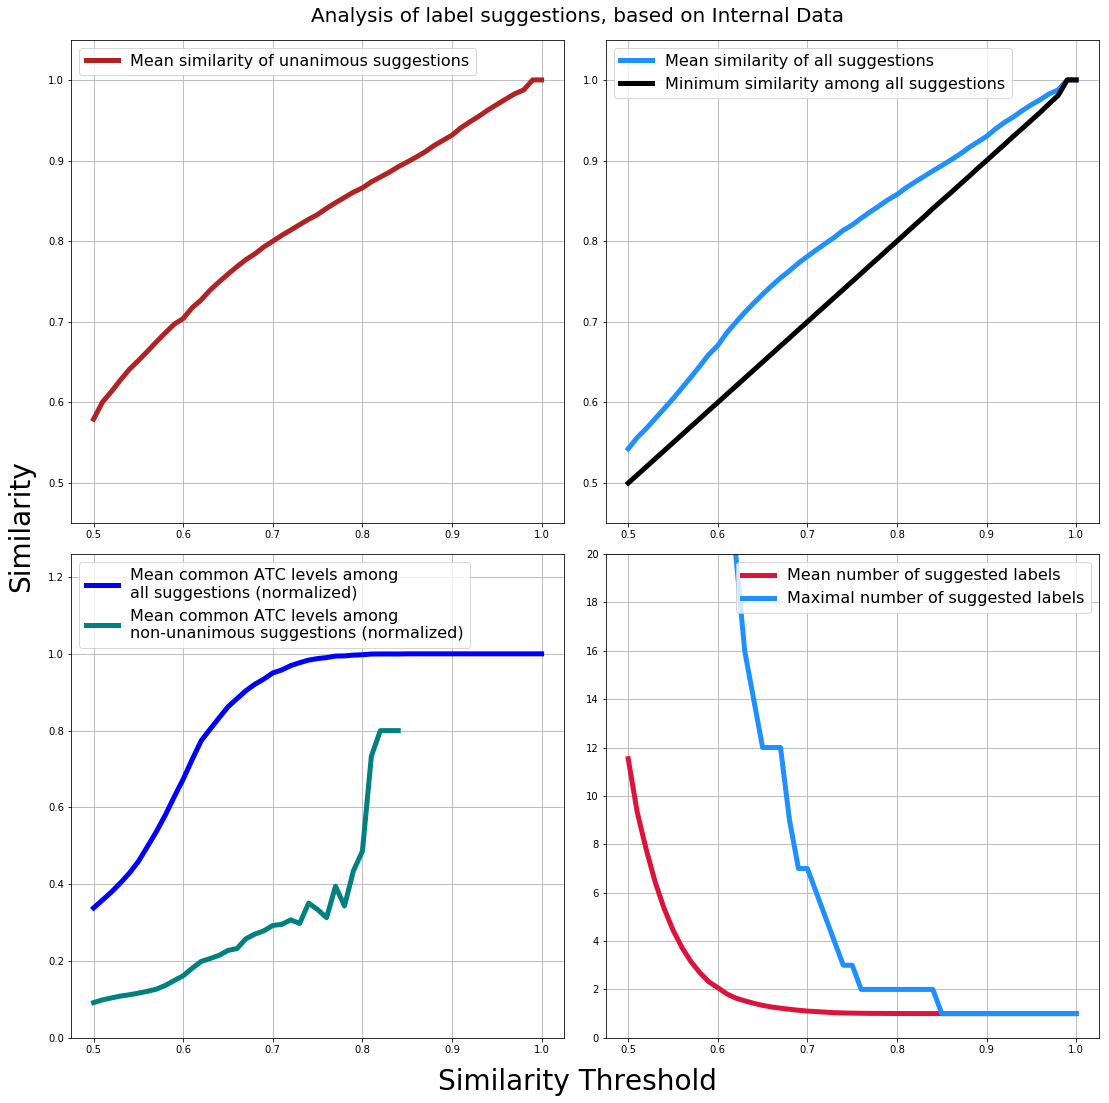

In [26]:
# fig_height = 15
# fig_width = 15

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                                             figsize=(fig_width, fig_height)
                                            )
#                                              sharex='col', sharey='row')

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

title='Analysis of label suggestions, based on Internal Data'
fig.suptitle(title, fontsize=20)

legend_font_size = 16

colors = ['firebrick', 'dodgerblue', 
          'k', 'b', 
          'teal', 'crimson', 
          'dodgerblue', 'y']

# top left
# ax1.set_title(title)
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous mean similarity'], 
         label='Mean similarity of unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0.45, 1.05])

# top right
# ax2.set_title(title)
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean similarity'], 
         label='Mean similarity of all suggestions',
         lw=5, 
         color=colors[1])
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Min similarity'], 
         label='Minimum similarity among all suggestions',
         lw=5, 
         color=colors[2])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0.45, 1.05])

# bottom left
# ax3.set_title(title)
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels (norm)'], 
         label='Mean common ATC levels among \nall suggestions (normalized)',
         lw=5, 
         color=colors[3])
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels, non-unanimous (norm)'], 
         label='Mean common ATC levels among \nnon-unanimous suggestions (normalized)',
         lw=5, 
         color=colors[4])
ax3.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax3.grid(True)
ax3.set_ylim([0.0, 1.26])

# bottom right
# ax4.set_title(title)
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean # suggestions'], 
         label='Mean number of suggested labels',
         lw=5, 
         color=colors[5])
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Max # suggestions'], 
         label='Maximal number of suggested labels',
         lw=5, 
         color=colors[6])
ax4.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax4.grid(True)
ax4.set_ylim([0, 20])
ax4.set_yticks(range(0,21, 2))

# ax4.set_yscale('log')

# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=28)
fig.text(-0.015, 0.5, 'Similarity', 
         ha='center', va='center', fontsize=28, 
         rotation='vertical')

# ax.set_xlim([-20, 20])
# ax.set_ylim([-20, 20])

# plt.show()

plt.savefig(figure_dir + 'suggestion_analysis_internal_similarities.pdf', bbox_inches='tight')

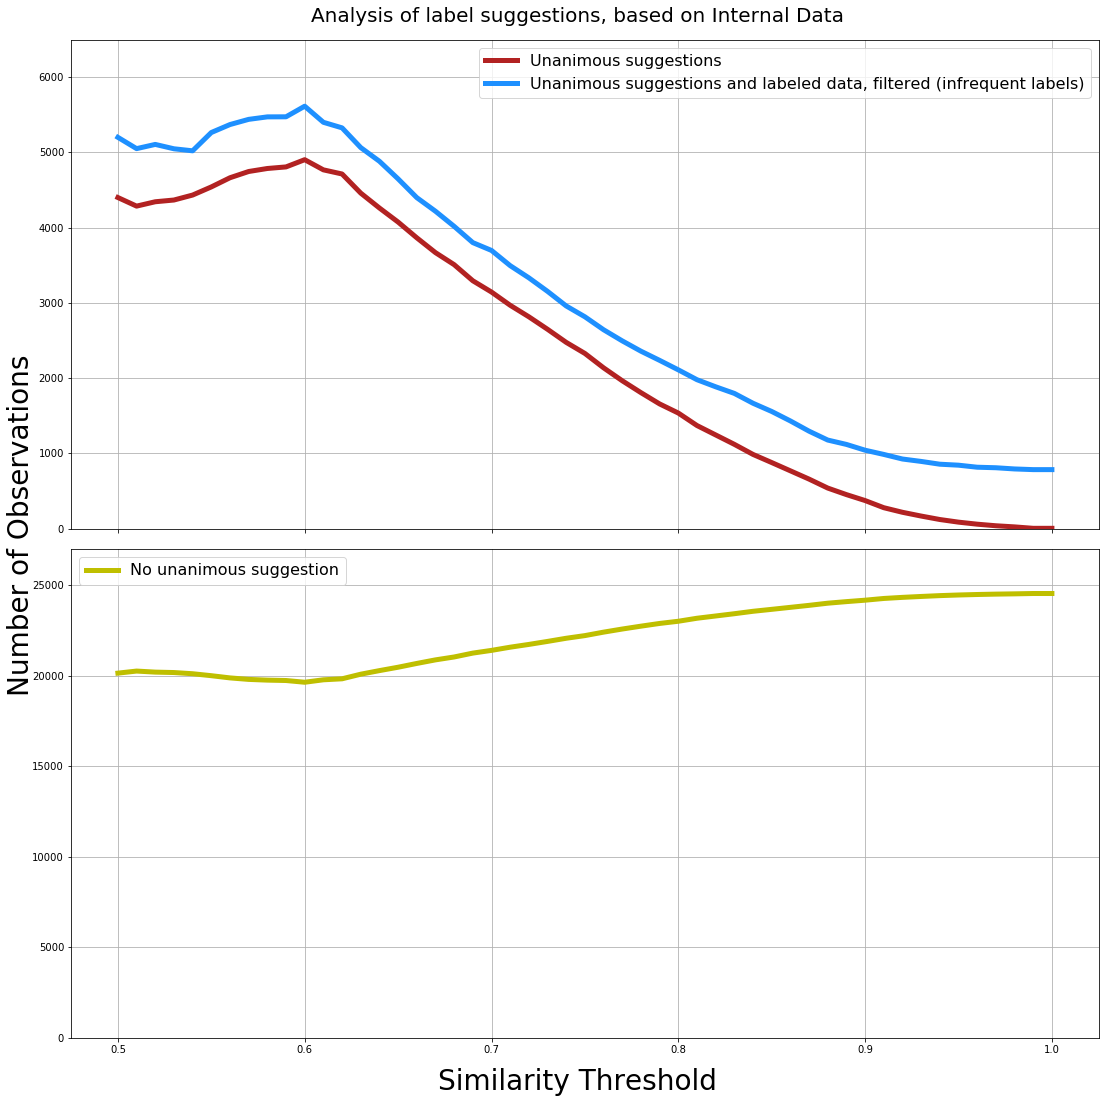

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, 
                         sharex=True, 
                         sharey=False,
                         figsize=(fig_width, fig_height))
# fig.subplots_adjust(0,0,1,1,0,0)

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

# title='Analysis of label suggestions, based on Internal Data'
fig.suptitle(title, fontsize=20)

legend_font_size = 16


ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions'], 
         label='Unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions and labeled data, filtered (infrequent labels)'], 
         label='Unanimous suggestions and labeled data, filtered (infrequent labels)',
         lw=5, 
         color=colors[1])
ax1.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0, 6500])


ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['No unanimous suggestion'], 
         label='No unanimous suggestion',
         lw=5, 
         color=colors[7])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0, 27000])

# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=28)
fig.text(-0.015, 0.5, 'Number of Observations', 
         ha='center', va='center', fontsize=28, 
         rotation='vertical')

plt.savefig(figure_dir + 'suggestion_analysis_internal_counts.pdf', bbox_inches='tight')

In [28]:
"""
Load data from **internal and external** sources from files, after files have been generated.
Generate some plots to try and understand the label suggestions results.
"""
sim_dict_filtered = load('resources/sim_dict_filtered_5_23')
# transform the ATC codes into class instances
sim_dict_filtered = \
    {k:[(Atc_code(atc), sim) for atc, sim in v] 
     for k,v in sim_dict_filtered.items()}

In [29]:
label_suggestion_summary = []
for threshold in np.linspace(0.5,1.0, 51):
# for threshold in np.linspace(0.5,1.0, 3):
    _, _, number_of_distinct_labels, \
        labels_sim_tup = \
        get_filtered_suggestion_results(threshold, 
                                        sim_dict_filtered)
    label_suggestion_summary.append(
        record_threshold_data(
            threshold, 
            number_of_distinct_labels, 
            labels_sim_tup, 
            x_unlabeled,
            y, 
            kwargs_lin_data_init)        
        )

In [30]:
label_suggestion_summary =  \
    pd.DataFrame(label_suggestion_summary)
    
# some float formatting
label_suggestion_summary_formatted = \
    label_suggestion_summary.head(5).style.format(
        {'Mean # suggestions': '{:.2f}', 
         'Mean similarity': '{:.2f}', 
         'Min similarity': '{:.2f}', 
         'Unanimous mean similarity': '{:.2f}', 
         'Mean common ATC levels (norm)': '{:.2f}', 
         'Mean common ATC levels, non-unanimous (norm)': '{:.2f}'})

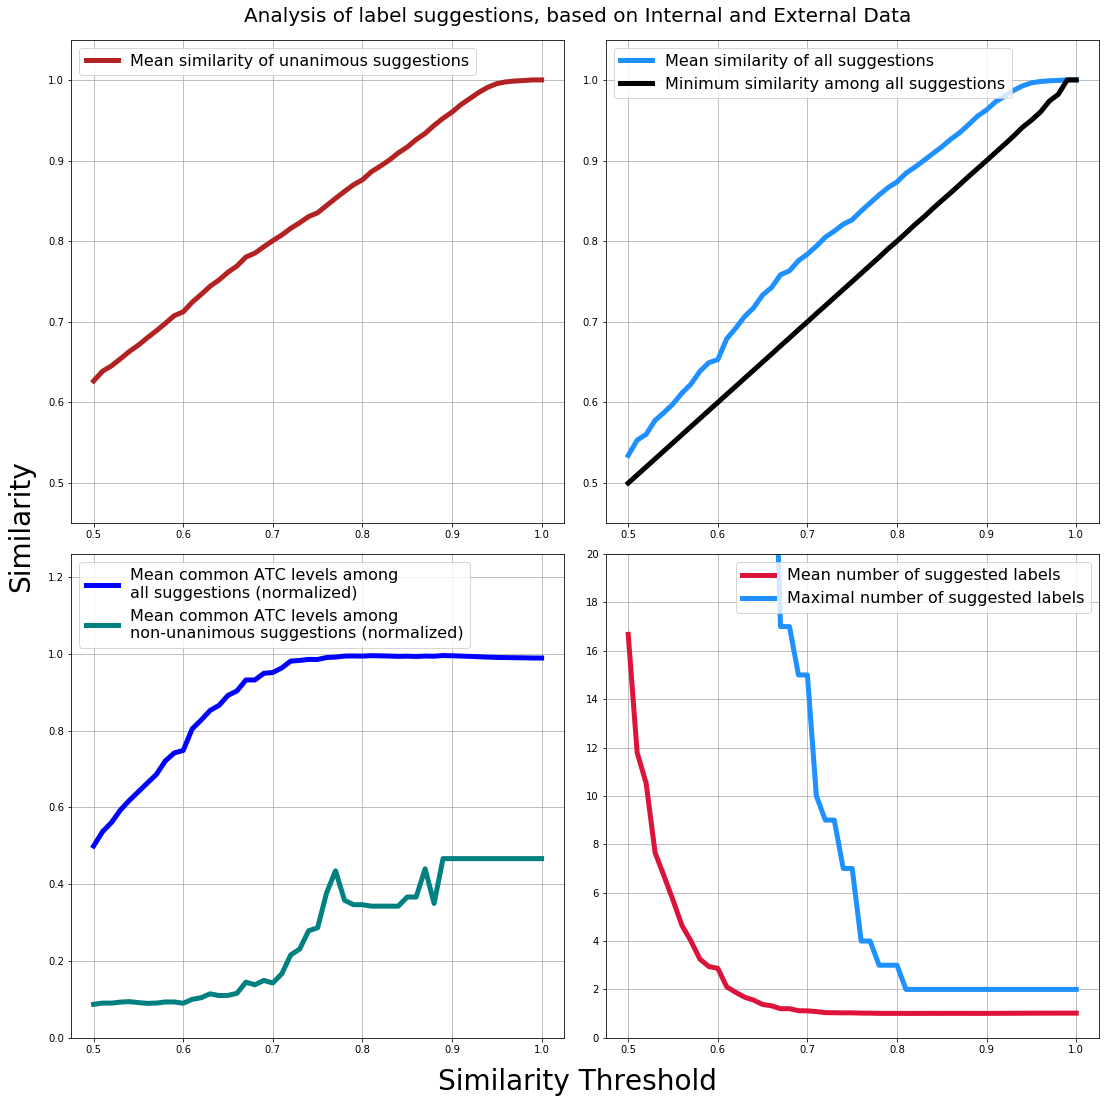

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                                             figsize=(fig_width, fig_height)
                                            )
#                                              sharex='col', sharey='row')

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

title='Analysis of label suggestions, based on Internal and External Data'
fig.suptitle(title, fontsize=20)

legend_font_size = 16

colors = ['firebrick', 'dodgerblue', 
          'k', 'b', 
          'teal', 'crimson', 
          'dodgerblue', 'y']

# top left
# ax1.set_title(title)
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous mean similarity'], 
         label='Mean similarity of unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0.45, 1.05])

# top right
# ax2.set_title(title)
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean similarity'], 
         label='Mean similarity of all suggestions',
         lw=5, 
         color=colors[1])
ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Min similarity'], 
         label='Minimum similarity among all suggestions',
         lw=5, 
         color=colors[2])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0.45, 1.05])

# bottom left
# ax3.set_title(title)
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels (norm)'], 
         label='Mean common ATC levels among \nall suggestions (normalized)',
         lw=5, 
         color=colors[3])
ax3.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean common ATC levels, non-unanimous (norm)'], 
         label='Mean common ATC levels among \nnon-unanimous suggestions (normalized)',
         lw=5, 
         color=colors[4])
ax3.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax3.grid(True)
ax3.set_ylim([0.0, 1.26])

# bottom right
# ax4.set_title(title)
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Mean # suggestions'], 
         label='Mean number of suggested labels',
         lw=5, 
         color=colors[5])
ax4.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Max # suggestions'], 
         label='Maximal number of suggested labels',
         lw=5, 
         color=colors[6])
ax4.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax4.grid(True)
ax4.set_ylim([0, 20])
ax4.set_yticks(range(0,21, 2))

# ax4.set_yscale('log')

# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=28)
fig.text(-0.015, 0.5, 'Similarity', 
         ha='center', va='center', fontsize=28, 
         rotation='vertical')

# ax.set_xlim([-20, 20])
# ax.set_ylim([-20, 20])

# plt.show()

plt.savefig(figure_dir + 'suggestion_analysis_external_similarities.pdf', bbox_inches='tight')

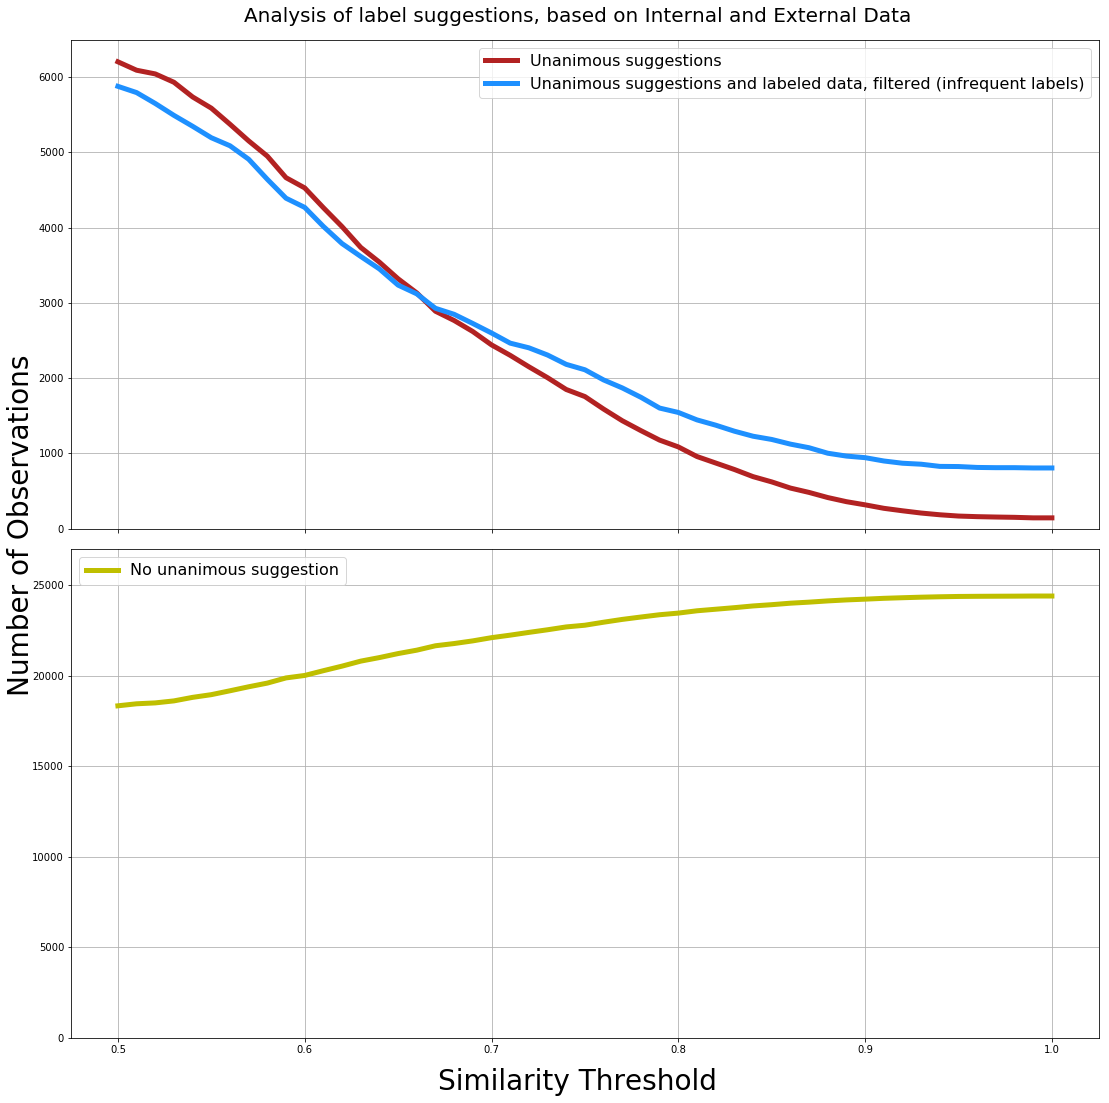

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2, 
                         sharex=True, 
                         sharey=False,
                         figsize=(fig_width, fig_height))
# fig.subplots_adjust(0,0,1,1,0,0)

fig.tight_layout()
fig.subplots_adjust(top=0.95)  # adjusting "tightness"

# title='Analysis of label suggestions, based on Internal Data'
fig.suptitle(title, fontsize=20)

legend_font_size = 16


ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions'], 
         label='Unanimous suggestions',
         lw=5, 
         color=colors[0])
ax1.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['Unanimous suggestions and labeled data, filtered (infrequent labels)'], 
         label='Unanimous suggestions and labeled data, filtered (infrequent labels)',
         lw=5, 
         color=colors[1])
ax1.legend(loc=1, fontsize=legend_font_size)  # 'upper right'
ax1.grid(True)
ax1.set_ylim([0, 6500])


ax2.plot(label_suggestion_summary['Threshold'], 
         label_suggestion_summary['No unanimous suggestion'], 
         label='No unanimous suggestion',
         lw=5, 
         color=colors[7])
ax2.legend(loc=2, fontsize=legend_font_size)  # 'upper right'
ax2.grid(True)
ax2.set_ylim([0, 27000])

# Set common labels
fig.text(0.5, -0.015, 'Similarity Threshold', 
         ha='center', va='center', fontsize=28)
fig.text(-0.015, 0.5, 'Number of Observations', 
         ha='center', va='center', fontsize=28, 
         rotation='vertical')

plt.savefig(figure_dir + 'suggestion_analysis_external_counts.pdf', bbox_inches='tight')

In [ ]:
# fill (area plot)
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.fill
# example:
# https://stackoverflow.com/questions/30209187/matplotlib-chart-area-vs-plot-area

In [5]:
"""
Load Patrick's assessment from file.
Plot and analyze the results, looking for an appropriate similarity threshold.
"""

fname_assessment_res = 'resources/Patricks_assessment_20170528_internal_data_WITH_SIM.csv'
assessment_res = pd.read_csv(
    fname_assessment_res, 
    delimiter=',', 
    header=0, 
    encoding='iso-8859-15', index_col='index')

# resetting index, such that the new index follows the direction of similarity
assessment_res = \
    assessment_res.sort_values('similarity').reset_index(drop=True)


assessment_grouped = \
    assessment_res[['similarity', 'patricks_assessment']].\
    groupby('patricks_assessment')


# assessment_grouped = assessment_res.groupby('patricks_assessment')
bins = lambda spread: \
    np.linspace(0.5,0.85, 
                round((0.85-0.5)/spread)+1)

In [18]:
patrick_feedback = \
    pd.DataFrame(OrderedDict([
        ('True', assessment_grouped.get_group(1).similarity),
        ('False', assessment_grouped.get_group(0).similarity)]
    ))

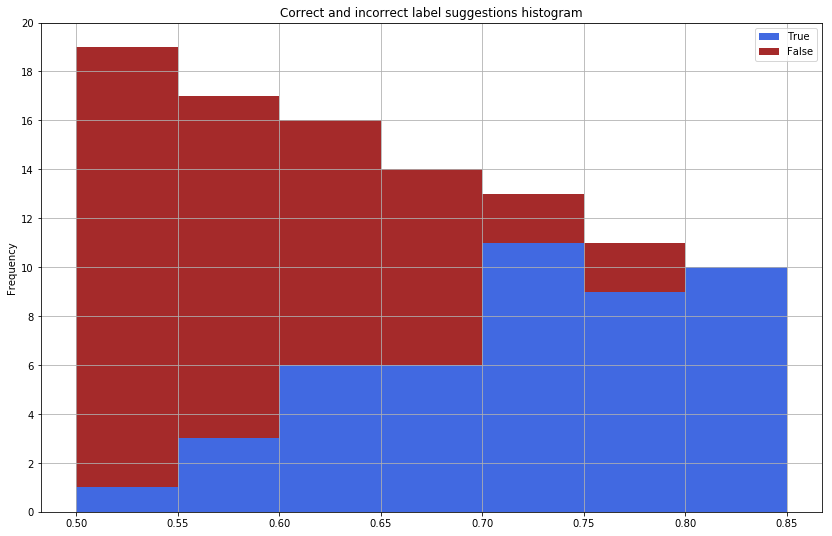

In [26]:
pd.DataFrame(OrderedDict([
    ('True', assessment_grouped.get_group(1).similarity),
    ('False', assessment_grouped.get_group(0).similarity)]
    ))\
    .plot.hist(stacked=True, 
               bins=bins(0.05), 
               figsize=(14, 9), 
               color=['royalblue', 'brown'], 
               title='Correct and incorrect label suggestions histogram', 
               grid=True, 
               yticks = range(0,21, 2)
)

plt.savefig(figure_dir + 'suggestion_feedback_hist.pdf', bbox_inches='tight')